# Chapter 3: Generating Images from Text Using DALL-E 2

## Downloading and Preparing Data

To download the dataset, visit the link https://cocodataset.org/#download and download the training and validation images for 2014 version along with their annotation files. The annotation files contain the mapping of image IDs to their captions. We will be training our model on the training data while monitoring the validation loss and once the model is trained, we can use it for zero-shot inferences from any data, hence we would not need test images. The MS-COCO dataset released in 2014 contains 164K images split into training (83K), validation (41K) and test (41K) sets. When you would download the dataset, it would download zip files for all the images, which are of different sizes, as well as the annotation files. Unzip the dataset into data/ directory. To load the (image, caption) pairs, we will create PyTorch's data loaders using datasets library.

In [1]:
! pip3 install -U torch==2.3.1
! pip3 install torchvision==0.17.2
! pip3 install pycocotools
! pip3 install transformers
! pip install timm
! pip install "numpy<2.0"

  Using cached torch-2.3.1-cp310-none-macosx_11_0_arm64.whl.metadata (26 kB)
Using cached torch-2.3.1-cp310-none-macosx_11_0_arm64.whl (61.0 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.2.2
    Uninstalling torch-2.2.2:
      Successfully uninstalled torch-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.17.2 requires torch==2.2.2, but you have torch 2.3.1 which is incompatible.
  Using cached torch-2.2.2-cp310-none-macosx_11_0_arm64.whl.metadata (25 kB)
Using cached torch-2.2.2-cp310-none-macosx_11_0_arm64.whl (59.7 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1
    Uninstalling torch-2.3.1:
      Successfully uninstalled torch-2.3.1
  Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl (14.0 MB)


In [2]:
import torch
from torchvision import datasets, transforms
import bisect

/Users/rajatgoel/Documents/Manning Book Multimodal AI/Book Git Repo/book-venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define data transforms
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Path to data
train_dir = '../../Personal Git Repo/data/train2014'
val_dir = '../../Personal Git Repo/data/val2014'
train_ann_file = '../../Personal Git Repo/data/annotations/captions_train2014.json'
val_ann_file = '../../Personal Git Repo/data/annotations/captions_val2014.json'

In [5]:
# Images are <class 'PIL.Image.Image'> before transformation
train_data = datasets.CocoCaptions(root=train_dir, annFile=train_ann_file, transform=image_transform)
val_data = datasets.CocoCaptions(root=val_dir, annFile=val_ann_file, transform=image_transform)

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [6]:
print('Number of samples: ', len(train_data))
img, target = train_data[3] # load 4th sample

print("Image Size: ", img.size())
print("Image ", type(img))
print(target)

Number of samples:  82783
Image Size:  torch.Size([3, 224, 224])
Image  <class 'torch.Tensor'>
['A zebra grazing on lush green grass in a field.', 'Zebra reaching its head down to ground where grass is. ', 'The zebra is eating grass in the sun.', 'A lone zebra grazing in some green grass.', 'a Zebra grazing on grass in a green open field.']


In [7]:
class CocoCaptionsFlattened(torch.utils.data.Dataset):
    def __init__(self, coco_captions):
        self.coco_captions = coco_captions
        print("Number of images:", len(self.coco_captions))
        caption_counts = [len(captions) for _, captions in coco_captions]
        self.cumulative_counts = self._compute_cumulative_counts(caption_counts)
        print("Number of image x caption pairs:", self.cumulative_counts[-1])

    def _compute_cumulative_counts(self, counts):
        cumulative = [0]
        for count in counts:
            cumulative.append(cumulative[-1] + count)
        return cumulative

    def __len__(self):
        return self.cumulative_counts[-1]

    def __getitem__(self, index):
        # Find the image index corresponding to the flattened caption index
        image_idx = bisect.bisect_right(self.cumulative_counts, index) - 1
        caption_idx = index - self.cumulative_counts[image_idx]
        # print(index, image_idx, caption_idx)
        image, captions = self.coco_captions[image_idx]
        return image, captions[caption_idx]

In [8]:
train_data_flattened = CocoCaptionsFlattened(train_data)

Number of images: 82783
Number of image x caption pairs: 414113


In [9]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data_flattened, batch_size=batch_size, shuffle=True)

In [ ]:
val_data_flattened = CocoCaptionsFlattened(val_data)

In [10]:
img, caption = train_data_flattened[10] # load 11th sample

print("Image Size: ", img.size())
print(caption)

Image Size:  torch.Size([3, 224, 224])
A flower vase is sitting on a porch stand.


## Load CLIP model

In [11]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/84/h1vtggnn11g_xs1m3kzfns4h0000gn/T/pip-req-build-ynv3y0ni
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/84/h1vtggnn11g_xs1m3kzfns4h0000gn/T/pip-req-build-ynv3y0ni
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [12]:
import clip

In [13]:
import torch
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint
from torch import nn, einsum
import torchvision.transforms as T

In [41]:
def resize_image_to(
    image,
    target_image_size,
    clamp_range = None,
    nearest = False,
    **kwargs
):
    orig_image_size = image.shape[-1]

    if orig_image_size == target_image_size:
        return image

    if not nearest:
        scale_factors = target_image_size / orig_image_size
        out = resize(image, scale_factors = scale_factors, **kwargs)
    else:
        out = F.interpolate(image, target_image_size, mode = 'nearest')

    if exists(clamp_range):
        out = out.clamp(*clamp_range)

    return out

In [42]:
class BaseClipAdapter(nn.Module):
    def __init__(self, clip, **kwargs):
        super().__init__()
        self.clip = clip
        self.overrides = kwargs

    def validate_and_resize_image(self, image):
        image_size = image.shape[-1]
        assert image_size >= self.image_size, f'you are passing in an image of size {image_size} but CLIP requires the image size to be at least {self.image_size}'
        return resize_image_to(image, self.image_size)

    @property
    def dim_latent(self):
        raise NotImplementedError

    @property
    def image_size(self):
        raise NotImplementedError

    @property
    def image_channels(self):
        raise NotImplementedError

    @property
    def max_text_len(self):
        raise NotImplementedError

    def embed_text(self, text):
        raise NotImplementedError

    def embed_image(self, image):
        raise NotImplementedError

In [47]:
from collections import namedtuple
EmbeddedText = namedtuple('EmbedTextReturn', ['text_embed', 'text_encodings'])
EmbeddedImage = namedtuple('EmbedImageReturn', ['image_embed', 'image_encodings'])

def l2norm(t):
    return F.normalize(t, dim = -1)

class OpenAIClipAdapter(BaseClipAdapter):
    def __init__(
        self,
        name = 'ViT-B/32'
    ):
        import clip
        openai_clip, preprocess = clip.load(name)
        super().__init__(openai_clip)
        self.eos_id = 49407 # for handling 0 being also '!'

        text_attention_final = self.find_layer('ln_final')

        self.dim_latent_ = text_attention_final.weight.shape[0]
        self.handle = text_attention_final.register_forward_hook(self._hook)

        self.clip_normalize = preprocess.transforms[-1]
        self.cleared = False

    def find_layer(self,  layer):
        modules = dict([*self.clip.named_modules()])
        return modules.get(layer, None)

    def clear(self):
        if self.cleared:
            return

        self.handle()

    def _hook(self, _, inputs, outputs):
        self.text_encodings = outputs

    @property
    def dim_latent(self):
        return self.dim_latent_

    @property
    def image_size(self):
        return self.clip.visual.input_resolution

    @property
    def image_channels(self):
        return 3

    @property
    def max_text_len(self):
        return self.clip.context_length

    @torch.no_grad()
    def embed_text(self, text):
        text = text[..., :self.max_text_len]

        is_eos_id = (text == self.eos_id)
        text_mask_excluding_eos = is_eos_id.cumsum(dim = -1) == 0
        text_mask = F.pad(text_mask_excluding_eos, (1, -1), value = True)
        text_mask = text_mask & (text != 0)
        assert not self.cleared

        text_embed = self.clip.encode_text(text)
        text_encodings = self.text_encodings
        text_encodings = text_encodings.masked_fill(~text_mask[..., None], 0.)
        del self.text_encodings
        return EmbeddedText(l2norm(text_embed.float()), text_encodings.float())

    @torch.no_grad()
    def embed_image(self, image):
        assert not self.cleared
        image = self.validate_and_resize_image(image)
        image = self.clip_normalize(image)
        image_embed = self.clip.encode_image(image)
        return EmbeddedImage(l2norm(image_embed.float()), None)

In [48]:
pretrained_clip = OpenAIClipAdapter()

In [49]:
train_data_iter = iter(train_loader)
first_batch = next(train_data_iter)
texts = list(first_batch[1])
images = first_batch[0]

In [50]:
# Test CLIP embedding generation
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenized_texts = clip.tokenize(texts).to(device)
clip_text_embeddings = pretrained_clip.embed_text(tokenized_texts)
clip_image_embeddings = pretrained_clip.embed_image(images)

In [53]:
print(clip_text_embeddings.text_embed.shape)
print(clip_text_embeddings.text_encodings.shape)
print(clip_image_embeddings.image_embed.shape)

torch.Size([32, 512])
torch.Size([32, 77, 512])
torch.Size([32, 512])


## Diffusion Process

### Helpers

In [98]:
def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def exists(val):
    return val is not None

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

In [57]:
def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype = torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

In [92]:
class NoiseScheduler(nn.Module):
    def __init__(self, *, timesteps):
        super().__init__()

        betas = cosine_beta_schedule(timesteps)

        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, axis = 0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)

        loss_fn = F.mse_loss
        self.loss_fn = loss_fn

        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32)) # register buffer helper function to cast double back to float

        register_buffer('betas', betas)
        register_buffer('alphas_cumprod', alphas_cumprod)
        register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)

        register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod)) # calculations for diffusion q(x_t | x_{t-1}) and others
        register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        register_buffer('log_one_minus_alphas_cumprod', torch.log(1. - alphas_cumprod))
        register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1. / alphas_cumprod))
        register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1. / alphas_cumprod - 1))

        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # calculations for posterior q(x_{t-1} | x_t, x_0)
        register_buffer('posterior_variance', posterior_variance)

        register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min =1e-20))) # log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        register_buffer('posterior_mean_coef1', betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod))
        register_buffer('posterior_mean_coef2', (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod))


    def sample_random_times(self, batch):
        return torch.randint(0, self.num_timesteps, (batch,), device = self.betas.device, dtype = torch.long)

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def q_sample(self, x_start, t, noise = None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    def q_sample_from_to(self, x_from, from_t, to_t, noise = None):
        shape = x_from.shape
        noise = default(noise, lambda: torch.randn_like(x_from))

        alpha = extract(self.sqrt_alphas_cumprod, from_t, shape)
        sigma = extract(self.sqrt_one_minus_alphas_cumprod, from_t, shape)
        alpha_next = extract(self.sqrt_alphas_cumprod, to_t, shape)
        sigma_next = extract(self.sqrt_one_minus_alphas_cumprod, to_t, shape)

        return x_from * (alpha_next / alpha) + noise * (sigma_next * alpha - sigma * alpha_next) / alpha

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def predict_noise_from_start(self, x_t, t, x0):
        return (
            (extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - x0) / \
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)
        )

In [93]:
# Test noise scheduler - forward diffusion
noise = torch.randn_like(img)
noise_scheduler = NoiseScheduler(timesteps=100)

In [107]:
from PIL import Image
from torchvision import transforms
from IPython.display import display, clear_output

def torch_tensor_to_image(tensor):
    # 1. Unnormalize the tensor
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean

    # 2. Clip the tensor values to [0, 1]
    tensor = torch.clamp(tensor, 0, 1)
    
    # Convert the tensor to a PIL Image
    to_pil = transforms.ToPILImage()
    image_pil = to_pil(tensor)
    return image_pil

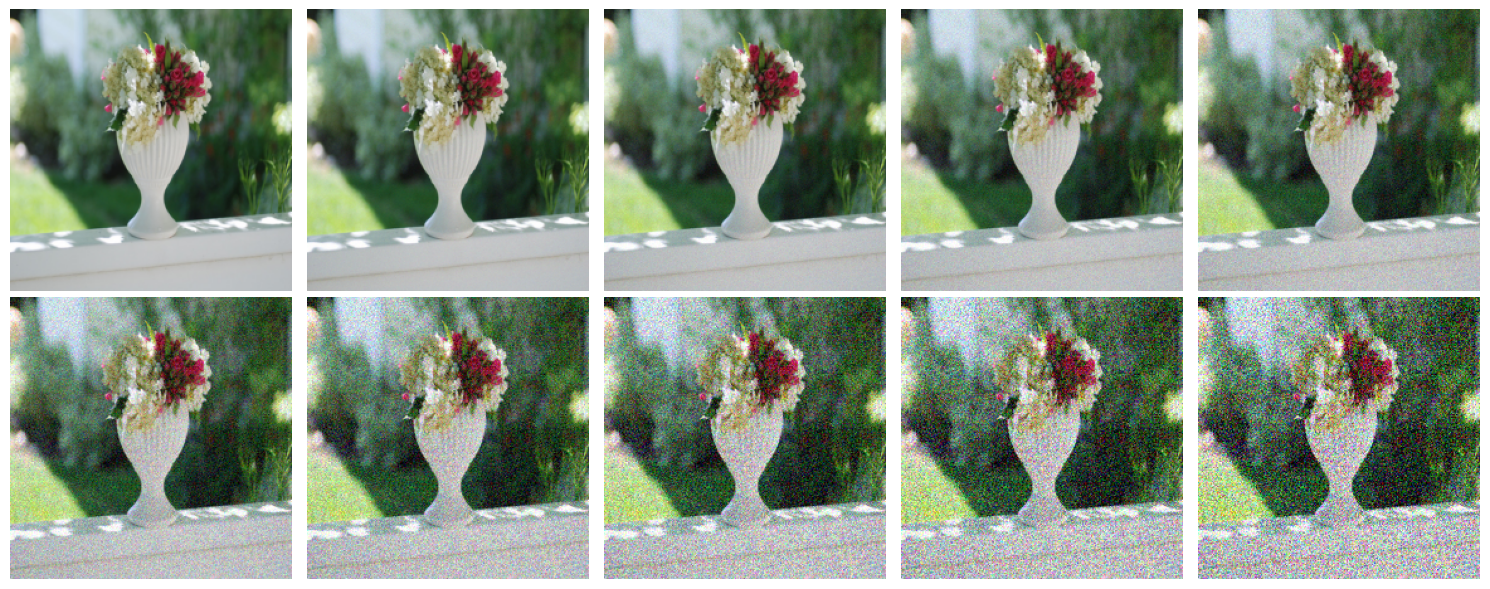

In [108]:
import matplotlib.pyplot as plt

img_copy = img.clone().detach()
plt.figure(figsize=(15, 6))  # Adjust figure size as needed
for t in range(10):
    pil_img = torch_tensor_to_image(img_copy)
    plt.subplot(2, 5, t + 1)
    plt.imshow(np.array(pil_img))
    plt.axis('off')
    
    img_copy = noise_scheduler.q_sample(img_copy, torch.tensor([t]), noise)

plt.tight_layout()
display(plt.gcf())  # Display the current figure
clear_output(wait=True) # Clear previous output, wait to prevent flickering.
plt.close() # Close the figure to prevent memory issues.

## Diffusion Prior Model